# **Ivan Murabito**
# Homework 2 DeepLearning and experiments on AlexNet




# Introduction

The purpose of this homework is to analyze and test the **AlexNet** convolutional network through various experiments;

- plain training and test

- transfer learning

- data augmentation



- **AlexNet**: created in 2012 by Alex Krizhevsky,
  it was the first convolutional network to use the RELU as an activation function, to add non-linearity and improve   its speed,
  and one of the first **deep** cnn to have important results in 2012 imageNet challenge.
  follow the classical convolutional network scheme:

  some conv layer followed by a pooling, and in the end of the network the FC layers.

  In particular AlexNet has 8 layers — 5 convolutional and 3 fully-connected, and about 62 Million parameters.


- **Dataset**: in this homework we use the caltech-101 dataset 
  which, as the name implies, has 102 classes and about 9k images including different objects.



# Training from scratch


### Install requirements



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip3 install --upgrade 'pillow'

Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (6.2.1)



### Import libraries

In this section i've installed and imported all stuffs needed for this homework (numpy,matplot,pil,torchvision etc etc)


In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import pandas as pd 
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from copy import deepcopy


### Set Arguments

Block of given arguments (LEARNING RATE,STEP_SIZE,EPOCHS etc)


In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR_TEST = 0.05
LR_TEST_2=0.001
LR = 0.001           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS_TEST = 70
NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE_TEST = 35  # How many epochs before decreasing learning rate (if using a step-down policy)
STEP_SIZE = 20
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 1

### Define Data Preprocessing


I defined the transformations to apply to images in the dataset (both training and evaluation),
at first:


*   resize (256)
*   center-crop (224)
*   to Tensor
*   normalize (mean=.5 .5 .5 ) (std=.5 .5 .5)




In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])


### My custom dataset (Caltech) class


I created my custom dataset class, starting from the one released.
that load the images respectively from given train.txt and test.txt files.
I created two new functions that help the creation of dataset

- load_images(..)
- find_classes(..)

(easy to imagine their purpose :))

the dataset class are:

- init(..) : initial processes, when data are loaded (from txt in this case)
- len(..) : return the size of data
- getitem(..) : return data and label at orbitary index


In [0]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys

TRAIN_PATH ='Homework2-Caltech101/train.txt'
TEST_PATH ='Homework2-Caltech101/test.txt'


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
def find_classes(txt_path):
    classes=[]
    f = open(txt_path)
    for l in f.readlines():
      x=l.split('/')
      if(not x[0] in classes): 
        classes.append(x[0])
    classes.remove('BACKGROUND_Google')
    #classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    print('FOUND {} CLASSES [{},{}..]'.format(len(classes),classes[0],classes[1]))
    return classes, class_to_idx

def load_images(root,txt_path,class_to_idx):
    images=[]
    f = open(txt_path)
    for path in f.readlines():
      label=path.split('/')[0]
      if(label in class_to_idx):
        image=(pil_loader(root+'/'+path.split('\n')[0]),class_to_idx[label])
        images.append(image)
    print('Loaded {} Images and label'.format(len(images)))
    return images
      


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        if(split == 'train'):
          self.txt_path=TRAIN_PATH
        if(split == 'test'):
          self.txt_path=TEST_PATH

        self.classes,self.class_to_idx=find_classes(self.txt_path) 

        self.samples=load_images(root,self.txt_path,self.class_to_idx) 
        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

         # Provide a way to access image and label via index
         # Image should be a PIL Image
         # label can be int

        image,label =self.samples[index]
        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.samples)
        return length

### Useful function

I wrote several usefull functions that I will use throughout the homework
in particular

- evaluate(..): test a model on given dataset
- plot_graph(..)
- train_and_validate(..): very useful function; given a model, optimizer, n_epoch and datasets and dataloaders



train the model and evaluate it on each epoch on validation set.

at the end (after last epoch) plot two graphs : loss / epochs accuracy / epochs
and returns the best model found

In [0]:
def evaluate(model,dataset,dataloader,type_='Validation'):
  model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  cudnn.benchmark # Calling this optimizes runtime
  model.train(False) # Set Network to evaluation mode
  accuracy=0
  running_corrects = 0
  for images, labels in dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    # Forward Pass
    outputs = model(images)
    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(dataset))
  print(' score: {:.4f} '.format(accuracy),end = '')
  return accuracy
  
def plot_graph(x,y,x_label,y_label):
  plt.figure(figsize=((10,8)))
  plt.plot(x,y, color='blue')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show() 

def train_and_validate(n_epoch,model,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler):
  '''
  train the model and validate it on each epoch, 
  return the model with best score on validation set
  '''
  model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  current_step = 0
  best_model={'accuracy':0}
  accuracies=[] # accuracy for epoch
  loss_=[]
  # Start iterating over the epochs
  
  for epoch in range(n_epoch):
    medium_loss=0
    count_step=0
    print('\nepoch {}/{}, LR = {} '.format(epoch+1, n_epoch, scheduler.get_lr()),end = '')
    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      model.train() # Sets module in training mode
      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients
      # Forward pass to the network
      outputs = model(images)
      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      # Log loss
      #if current_step % LOG_FREQUENCY == 0:
        #print('Step {}, Loss {}'.format(current_step, loss.item()))
      medium_loss+=loss.item()
      count_step+=1
      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients
      current_step += 1
    medium_loss=medium_loss/count_step
    loss_.append(medium_loss)
    print(' loss : {:.4f}'.format(medium_loss),end = '')
    accuracy=evaluate(model,val_dataset,val_dataloader,type_='validation')
    accuracies.append(accuracy)
    if(accuracy > best_model['accuracy']):
      print(' BEST!',end='')
      best_model['accuracy']=accuracy
      best_model['model']=deepcopy(model)
    scheduler.step()
  best_model['accuracies']=accuracies
  #ACCURACY/EPOCH GRAPH
  plot_graph(range(n_epoch),accuracies,'Epoch','Accuracy') 
  #loss/epoch graph
  plot_graph(range(n_epoch),loss_,'Epoch','medium loss')

  return best_model

### Prepare Dataset
in this section i loaded two dataset from .txts; train and test (5784 images for train and 2893 for test)
nb: 
obviously the images are balanced for each class.

In [29]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'

# Prepare Pytorch train/test Datasets
train_dataset= Caltech(DATA_DIR,'train',transform=train_transform)
test_dataset= Caltech(DATA_DIR,'test',transform=eval_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

FOUND 101 CLASSES [accordion,airplanes..]
Loaded 5784 Images and label
FOUND 101 CLASSES [accordion,airplanes..]
Loaded 2893 Images and label
Train Dataset: 5784
Test Dataset: 2893


### Split train into train and validation




I've splitted train in train and validation (each 2892 images),
to maintain the balance I used odd indexes for validation and even for training.
(nb: this trick work only because the images are ordered)
for all the homework these datasets will be used.


In [30]:
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]
val_indexes=[i+1 for i in train_indexes]

val_dataset=Subset(train_dataset,val_indexes)
train_dataset=Subset(train_dataset,train_indexes)
print('Training split: {}'.format(len(train_dataset)))
print('Validation split: {}'.format(len(val_dataset)))



Training split: 2892
Validation split: 2892


### Prepare Dataloaders

from pytorch docs:

`Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.`

Dataloaders help to put in ram a batch of data from dataset, help with parallelization and provide some usefull tools like shuffling and more.
there is a dataloader for each split (train,test,val)


In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


### Prepare Network

- Load the Alexnet (pytorch implementation) 
- change fc layer from 1000 output to 101 output (caltech classes)

In [0]:
net = alexnet() # Loading AlexNet model
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

### Prepare Training

Define:


*   criterion: cross entropy
*   param to oprimize: at firsts step of homework i will optimize all params of network (net.parameters())
*   optimizer: the optimizer update the weights based on the loss,in this case is used SGD with momentum
*   scheduler : dynamically change the LR 



In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR_TEST, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE_TEST, gamma=GAMMA)

## Train


To find a good model I didn't put all the parameters to optimize in a double/triple for (like a gridSearch)
but I did several experiments analyzing the progress of each model, first modifying the learning rate (the one given to me was too small, especially after splitting the train in train + validation)
and then the step size and the number of epochs.
for each epoch the model is evaluated on validation set.
the printed output below show the epoch,loss,val_score
at the end two graphs showing the trend of these variables over the epochs.
the printed output below show (..one of) the best model that i found over experiments:

- **LR:0.05**

- **50 epochs**

- **step size:35** 





epoch 1/50, LR = [0.05]  loss : 4.5911 score: 0.0923  BEST!
epoch 2/50, LR = [0.05]  loss : 4.3924 score: 0.0923 
epoch 3/50, LR = [0.05]  loss : 4.2419 score: 0.0930  BEST!
epoch 4/50, LR = [0.05]  loss : 4.1754 score: 0.0972  BEST!
epoch 5/50, LR = [0.05]  loss : 4.1184 score: 0.1145  BEST!
epoch 6/50, LR = [0.05]  loss : 4.0238 score: 0.1957  BEST!
epoch 7/50, LR = [0.05]  loss : 3.7824 score: 0.2258  BEST!
epoch 8/50, LR = [0.05]  loss : 3.6626 score: 0.2192 
epoch 9/50, LR = [0.05]  loss : 3.4860 score: 0.2749  BEST!
epoch 10/50, LR = [0.05]  loss : 3.2764 score: 0.2988  BEST!
epoch 11/50, LR = [0.05]  loss : 3.2311 score: 0.2932 
epoch 12/50, LR = [0.05]  loss : 3.0501 score: 0.2828 
epoch 13/50, LR = [0.05]  loss : 2.8514 score: 0.3461  BEST!
epoch 14/50, LR = [0.05]  loss : 3.1087 score: 0.2943 
epoch 15/50, LR = [0.05]  loss : 3.0103 score: 0.3513  BEST!
epoch 16/50, LR = [0.05]  loss : 2.6146 score: 0.3828  BEST!
epoch 17/50, LR = [0.05]  loss : 2.4033 score: 0.3987  BEST!
e

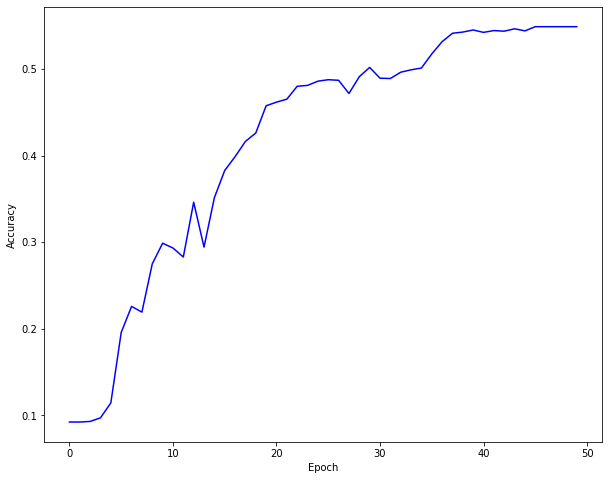

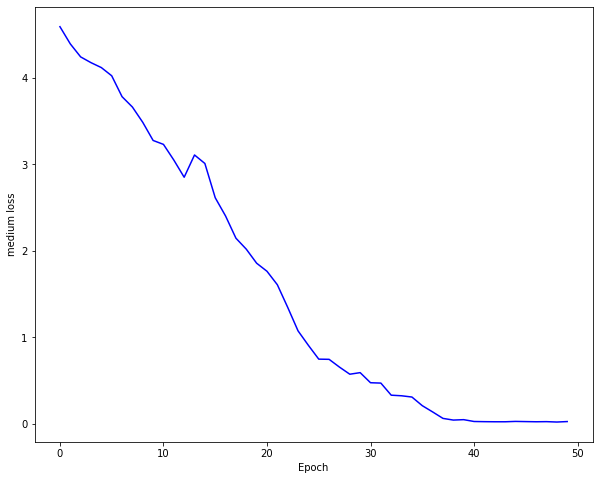

In [34]:
# Train and evaluate with my custom function, return the best model found on all epochsa
# print 2 graphs showing ho varies the accuracy and the loss trough the epochs
best_model=train_and_validate(50,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)

## Test
evaluate the best model on test set

In [35]:
net = best_model['model']
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode
accuracy=evaluate(net,test_dataset,test_dataloader,type_='test set ')


 score: 0.5465 

| LR            | EPOCH      | STEP       | LOSS    | MAX SCORE ON VALIDATION SET | SCORE ON TEST |
| ------------- | ---------- | ---------- | ------- | --------------------------- | ------------- |
| 0.1           | 30         | 20         | diverge |                             |               |
| 0.05          | 60         | 20         | 0.34    | 0.47                        |               |
| 0.05          | 40         | 10         | 3.9     | 0.12                        |               |
| 0.05          | 50         | 35         | 0.02   | 0.55                        | 0.54          |
| 0.01          | 40         | 25         | 0.37    | 0.34                        |
|               |
| 0.001 (stock) | 30 (stock) | 20 (stock) | 2.5     | 0.16                        |


as you can see from the table there is a lot of difference in the results of the various tests with different hyperparameters.
it can be noted, however, that the starting learning rate 0.001 is too small to converge in acceptable times/epochs.
nb: i evaluated on test set only the best model that i found, all others models are evaluated (for each epochs) only on validation set, and the validation score refers only the best model in all iterations.
instead the loss is the loss at the last epochs.

# Transfer Learning

in this section I do the same experiments as before but this time on the pretrained net (on imagenet). 
it can be seen that the pretrained network converges much much faster, so I preferred to use fewer epochs also to reduce the execution time!

### Prepare dataset with new transform (mean and std of imageNet)

the procedure is the same as before but this time in the normalize function (into transforms) i use mean and std of imagenet:

*   mean: (0.485, 0.456, 0.406),
*   std:   (0.229, 0.224, 0.225)





In [38]:
# params
LR = 0.01           # The initial Learning Rate
NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15

# normalize function with mean and standard deviation of imagenet
alex_pretrained_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

train_dataset= Caltech(DATA_DIR,'train',transform=alex_pretrained_transform)  # make dataset with custom transform (mean and std of imagenet)
test_dataset= Caltech(DATA_DIR,'test',transform=alex_pretrained_transform)
# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]
val_indexes=[i+1 for i in train_indexes]
#train and val
val_dataset=Subset(train_dataset,val_indexes)
train_dataset=Subset(train_dataset,train_indexes)

print('Training split: {}'.format(len(train_dataset)))
print('Validation split: {}'.format(len(val_dataset)))
#dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

FOUND 101 CLASSES [accordion,airplanes..]
Loaded 5784 Images and label
FOUND 101 CLASSES [accordion,airplanes..]
Loaded 2893 Images and label
Train Dataset: 5784
Test Dataset: 2893
Training split: 2892
Validation split: 2892


### Load alexnet pretrained


the procedure is the same as before ,except for:


```
net = alexnet(pretrained=True)
```



In [0]:
net = alexnet(pretrained=True) # Loading AlexNet model pretrained
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

### Alexnet structure:

In [40]:
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### **Train the model pretrained** and found best hyper-params


epoch 1/20, LR = [0.01]  loss : 2.9812 score: 0.6314  BEST!
epoch 2/20, LR = [0.01]  loss : 0.8728 score: 0.7790  BEST!
epoch 3/20, LR = [0.01]  loss : 0.3481 score: 0.8074  BEST!
epoch 4/20, LR = [0.01]  loss : 0.1828 score: 0.8223  BEST!
epoch 5/20, LR = [0.01]  loss : 0.1294 score: 0.8133 
epoch 6/20, LR = [0.01]  loss : 0.0848 score: 0.8268  BEST!
epoch 7/20, LR = [0.01]  loss : 0.0531 score: 0.8281  BEST!
epoch 8/20, LR = [0.01]  loss : 0.0510 score: 0.8420  BEST!
epoch 9/20, LR = [0.01]  loss : 0.0400 score: 0.8361 
epoch 10/20, LR = [0.01]  loss : 0.0195 score: 0.8382 
epoch 11/20, LR = [0.01]  loss : 0.0198 score: 0.8416 
epoch 12/20, LR = [0.01]  loss : 0.0103 score: 0.8482  BEST!
epoch 13/20, LR = [0.01]  loss : 0.0145 score: 0.8479 
epoch 14/20, LR = [0.01]  loss : 0.0150 score: 0.8413 
epoch 15/20, LR = [0.01]  loss : 0.0095 score: 0.8492  BEST!
epoch 16/20, LR = [0.001]  loss : 0.0052 score: 0.8510  BEST!
epoch 17/20, LR = [0.001]  loss : 0.0068 score: 0.8524  BEST!
epoch

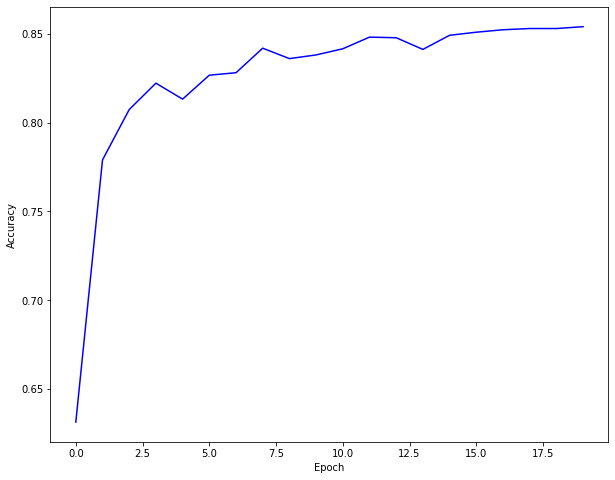

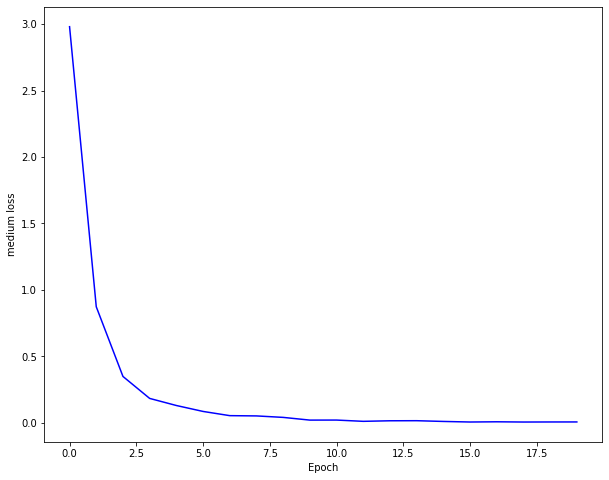

In [41]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
best_model_pretrained=train_and_validate(NUM_EPOCHS,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)


| lr    | epochs | step | loss   | score (validation) |
| ----- | ------ | ---- | ------ | ------------------ |
| 0.05  | 20     | 15   | div!   | div!               |
| 0.01  | 20     | 15   | 0.001  | 0.854              |
| 0.01  | 30     | 15   | 0.0012 | 0.852              |
| 0.008 | 20     | 15   | 0.0024 | 0.85               |
| 0.005 | 15     | 10   | 0.007  | 0.84               |
| 0.005 | 30     | 25   | 0.002  | 0.853              |
| 0.001 | 30     | 25   | 0.0015 | 0.83               |



as you can see the results are much better than the previous model.
even at the second epoch we reach a 75% accuracy on the validation set, which for me is a very good result;
until the accuracy reach, after 20 epoch, just over 85%, impressive!

but i tuned again different hyperparameters because the best ones in the "not pretrained" model didn't perform very well.


*i could even continue to decrease the number of epochs and by making a more precise tuning, obtain even better results*



In [42]:
net = best_model_pretrained['model']
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

accuracy=evaluate(net,test_dataset,test_dataloader,'test')


 score: 0.8496 

## **Freezing layer**
- LR= 0.01
- 20 epochs
- step size = 15


in this section I try the hyper-parameters found previously:

- freezing the convolutional layers
- freezing the fully connected layers


In [0]:
LR = 0.01           # best params
NUM_EPOCHS = 20     
STEP_SIZE = 15

### Training and test freezing convolutional layers


epoch 1/20, LR = [0.01]  loss : 2.9148 score: 0.6670  BEST!
epoch 2/20, LR = [0.01]  loss : 0.8320 score: 0.8026  BEST!
epoch 3/20, LR = [0.01]  loss : 0.3365 score: 0.8174  BEST!
epoch 4/20, LR = [0.01]  loss : 0.1628 score: 0.8358  BEST!
epoch 5/20, LR = [0.01]  loss : 0.0940 score: 0.8389  BEST!
epoch 6/20, LR = [0.01]  loss : 0.0598 score: 0.8409  BEST!
epoch 7/20, LR = [0.01]  loss : 0.0505 score: 0.8434  BEST!
epoch 8/20, LR = [0.01]  loss : 0.0371 score: 0.8437  BEST!
epoch 9/20, LR = [0.01]  loss : 0.0342 score: 0.8423 
epoch 10/20, LR = [0.01]  loss : 0.0306 score: 0.8458  BEST!
epoch 11/20, LR = [0.01]  loss : 0.0293 score: 0.8416 
epoch 12/20, LR = [0.01]  loss : 0.0322 score: 0.8416 
epoch 13/20, LR = [0.01]  loss : 0.0247 score: 0.8413 
epoch 14/20, LR = [0.01]  loss : 0.0233 score: 0.8485  BEST!
epoch 15/20, LR = [0.01]  loss : 0.0179 score: 0.8489  BEST!
epoch 16/20, LR = [0.001]  loss : 0.0155 score: 0.8482 
epoch 17/20, LR = [0.001]  loss : 0.0174 score: 0.8482 
epoch

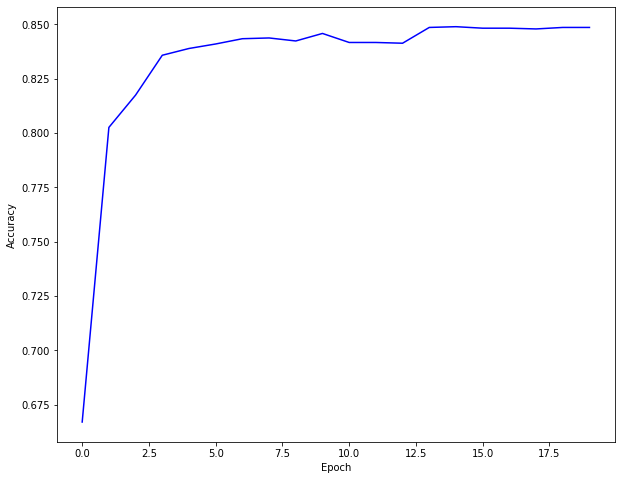

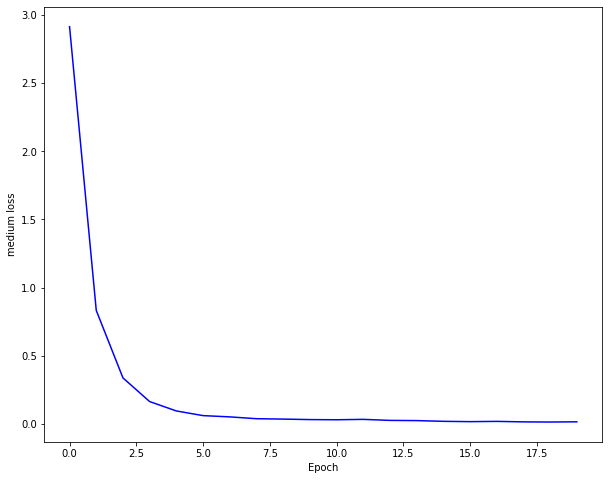

 score: 0.8441 

In [44]:
net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.classifier.parameters() # only full connected layer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) 
cudnn.benchmark
best_model_full_connected=train_and_validate(NUM_EPOCHS,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)
accuracy=evaluate(best_model_full_connected['model'],test_dataset,test_dataloader,'(full conn layers) test')

### Training and freezing the fully connected layers



epoch 1/20, LR = [0.01]  loss : 4.6834 score: 0.0747  BEST!
epoch 2/20, LR = [0.01]  loss : 4.2454 score: 0.2358  BEST!
epoch 3/20, LR = [0.01]  loss : 3.7166 score: 0.2839  BEST!
epoch 4/20, LR = [0.01]  loss : 3.4482 score: 0.3164  BEST!
epoch 5/20, LR = [0.01]  loss : 3.3001 score: 0.3278  BEST!
epoch 6/20, LR = [0.01]  loss : 3.1533 score: 0.3565  BEST!
epoch 7/20, LR = [0.01]  loss : 3.0402 score: 0.3385 
epoch 8/20, LR = [0.01]  loss : 2.9637 score: 0.3762  BEST!
epoch 9/20, LR = [0.01]  loss : 2.8535 score: 0.3838  BEST!
epoch 10/20, LR = [0.01]  loss : 2.7974 score: 0.3994  BEST!
epoch 11/20, LR = [0.01]  loss : 2.6833 score: 0.4080  BEST!
epoch 12/20, LR = [0.01]  loss : 2.5698 score: 0.3925 
epoch 13/20, LR = [0.01]  loss : 2.5440 score: 0.4457  BEST!
epoch 14/20, LR = [0.01]  loss : 2.3931 score: 0.4637  BEST!
epoch 15/20, LR = [0.01]  loss : 2.3154 score: 0.4720  BEST!
epoch 16/20, LR = [0.001]  loss : 2.1546 score: 0.4820  BEST!
epoch 17/20, LR = [0.001]  loss : 2.0965 sc

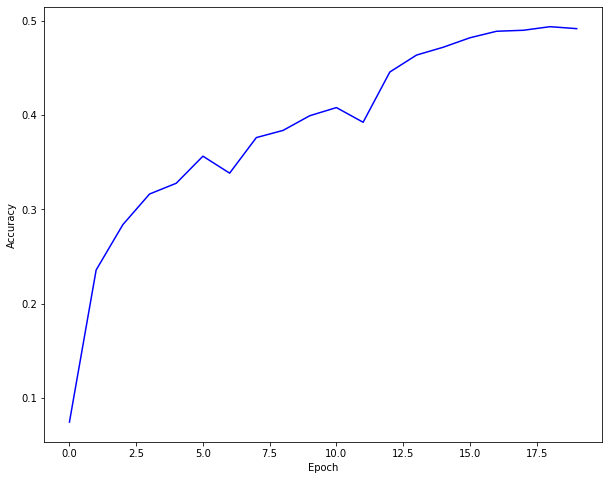

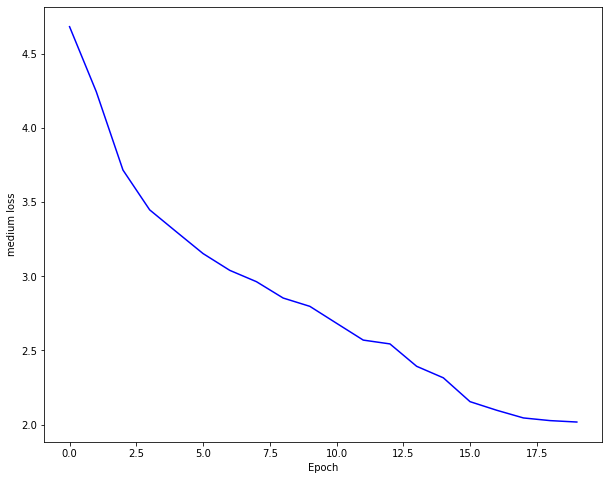

 score: 0.4860 

In [45]:
net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.features.parameters() # only fully connected layer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) 
cudnn.benchmark
best_model_conv=train_and_validate(NUM_EPOCHS,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)
accuracy=evaluate(best_model_conv['model'],test_dataset,test_dataloader,'(conv layers) test')

**Compare results**

as it was easy to imagine,training only the FC, the model converge much much faster then training only the CONV,

in this case even the results (training only FC) are a very very similiar than training the entire network!

this is because normally when we do transfer learning it is good practice to do fine-tuning on the highest levels of the network,And not on all levels.
this because going down deep on the net, the first layers are those that identify more generic features, such as borders, shadows etc,
while the layers at the upper (generally the FC layers) are those that identify more specific features.
we do not need to re-train also the convolutionary layers because their weights are already adequate.

| type of training (layers) | loss  | score(val) | score(test) |
| ------------------------- | ----- | ---------- | ----------- |
| all                       | 0.001 | 0.85       | 0.85        |
| only Fully connected      | 0.01  | 0.84       | 0.84        |
| only convolutional        | 2     | 0.49       | 0.48        |

ACCURACY OBTAINED WHEN TRAINING FULLY CONNECTED LAYER


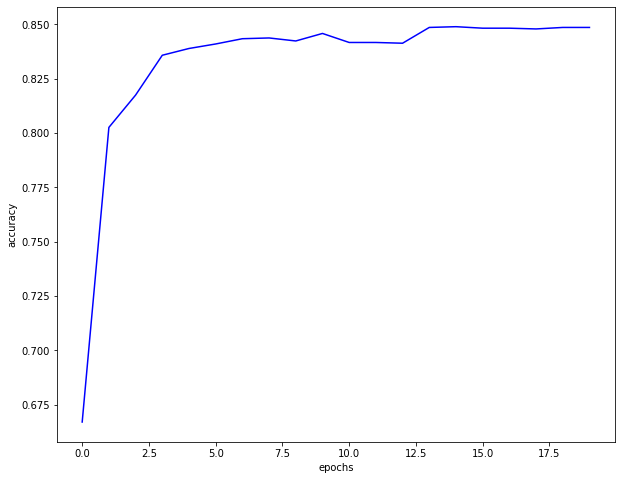

ACCURACY OBTAINED WHEN TRAINING CONVOLUTIONAL LAYER


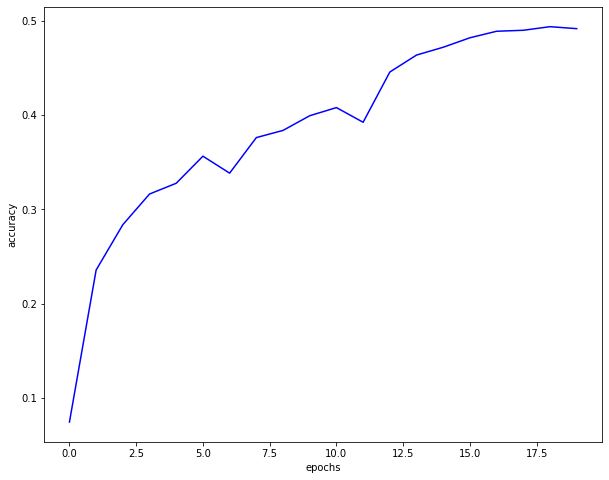

In [49]:
print('ACCURACY OBTAINED WHEN TRAINING FULLY CONNECTED LAYER')
plot_graph(range(NUM_EPOCHS),best_model_full_connected['accuracies'],'epochs','accuracy')
print('ACCURACY OBTAINED WHEN TRAINING CONVOLUTIONAL LAYER')
plot_graph(range(NUM_EPOCHS),best_model_conv['accuracies'],'epochs','accuracy')

# Data augmentation

in this section I experiment with different types of image transformations:
- (stock) centerCrop
- randomCrop
- centerCrop + randomHorizontalFlip
- centerCrop + randomRotation(180°)

## Prepare datasets with new transforms

In [52]:
LR = 0.01           # best params
NUM_EPOCHS = 20     
STEP_SIZE = 15

# normalize function with mean and standard deviation
transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
transform_1 = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
transform_2 = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
transform_3 = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomRotation(180),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
print('[stock transforms]\n',transform)
print('[transforms #1]\n',transform_1)
print('[transform #2]\n',transform_2)
print('[transform #3]\n',transform_3)


train_dataset= Caltech(DATA_DIR,'train',transform=transform_3)  # make dataset with custom transform (mean and std of imagenet)
test_dataset= Caltech(DATA_DIR,'test',transform=eval_transform)
# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]
val_indexes=[i+1 for i in train_indexes]
#train and val
val_dataset=Subset(train_dataset,val_indexes)
train_dataset=Subset(train_dataset,train_indexes)

print('Training split: {}'.format(len(train_dataset)))
print('Validation split: {}'.format(len(val_dataset)))
#dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



[stock transforms]
 Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
[transforms #1]
 Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    RandomCrop(size=(224, 224), padding=None)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
[transform #2]
 Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
[transform #3]
 Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    RandomRotation(degrees=(-180, 180), resample=False, expand=False)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
FOUND 101 CLASSES [accordion,airplanes..]
Loaded 5784 Images and label
FOUND 101 CLASSE

### Test the new transformations


epoch 1/20, LR = [0.01]  loss : 3.6166 score: 0.4308  BEST!
epoch 2/20, LR = [0.01]  loss : 2.0666 score: 0.5778  BEST!
epoch 3/20, LR = [0.01]  loss : 1.3252 score: 0.6241  BEST!
epoch 4/20, LR = [0.01]  loss : 1.0635 score: 0.6345  BEST!
epoch 5/20, LR = [0.01]  loss : 0.8243 score: 0.6421  BEST!
epoch 6/20, LR = [0.01]  loss : 0.6909 score: 0.6546  BEST!
epoch 7/20, LR = [0.01]  loss : 0.6029 score: 0.6553  BEST!
epoch 8/20, LR = [0.01]  loss : 0.5582 score: 0.6598  BEST!
epoch 9/20, LR = [0.01]  loss : 0.4692 score: 0.6656  BEST!
epoch 10/20, LR = [0.01]  loss : 0.3781 score: 0.6587 
epoch 11/20, LR = [0.01]  loss : 0.3247 score: 0.6622 
epoch 12/20, LR = [0.01]  loss : 0.3288 score: 0.6622 
epoch 13/20, LR = [0.01]  loss : 0.2789 score: 0.6584 
epoch 14/20, LR = [0.01]  loss : 0.2192 score: 0.6736  BEST!
epoch 15/20, LR = [0.01]  loss : 0.2246 score: 0.6763  BEST!
epoch 16/20, LR = [0.001]  loss : 0.1370 score: 0.6895  BEST!
epoch 17/20, LR = [0.001]  loss : 0.0971 score: 0.6850 

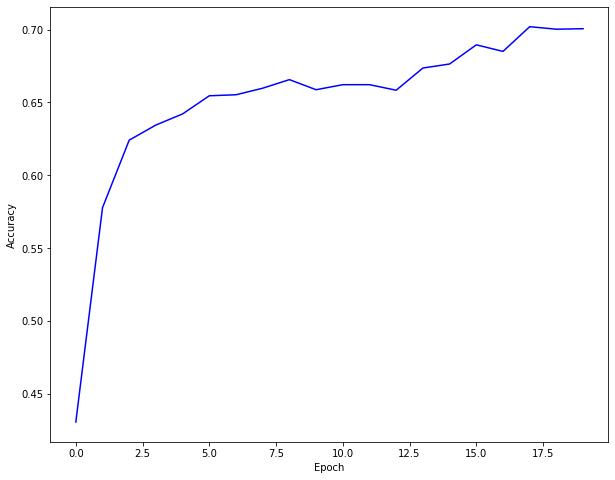

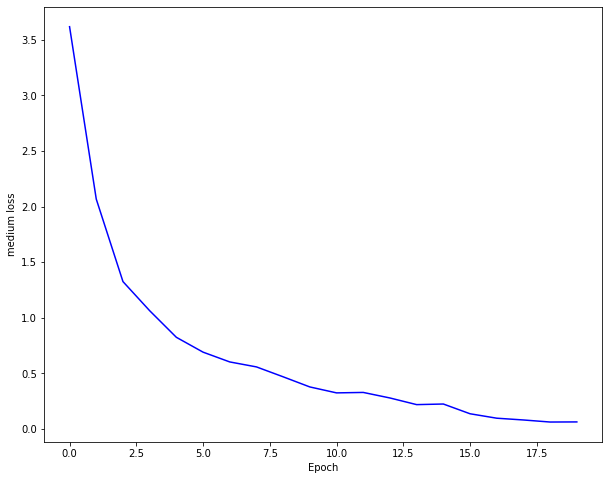

 score: 0.6371 

In [53]:
net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() # all params
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) 
cudnn.benchmark
best_model_augmentation=train_and_validate(NUM_EPOCHS,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)
accuracy=evaluate(best_model_augmentation['model'],test_dataset,test_dataloader,'test')

|       | transforms                            | loss  | score (test) |
|-------|--------------------------------------|-------|--------------|
| stock | center-crop                          | 0.001 | 0.85         |
| 1     | random crop                          | 0.018 | 0.833        |
| 2     | center-crop + random horizontal flip | 0.01  | 0.78       |
| 3     | center-crop + random rotation (180°) | 0.07  | 0.64          |


this time I couldn't get better results than the previous ones (but quite similar).
however I think that using different types of transformations greatly helps to reduce overfitting (wee can see this on the loss wich is medium higher than the previous) and improve accuracy

*Another way can be increase the cardinality of data by concatenate different sets with different transformations*

# **Beyond AlexNet**

## **Resnet**
*Very deep network using residual connection.*

Resnet is very different model and much deeper than alexnet;

it starts from the hypothesis that deep models are more difficult to optimize;

solution: use layers to fit residual F(x) = H(x) + x instead of H(x) directly

resnet is composed by "residual blocks", every block has two 3x3 conv layers

since the network is much deeper, it is necessary to lower (even a lot!) the batch size to avoid saturating the gpu ram.

*I've also tried the **vgg16** but i couldn't get it to work at its best, and the training was really really slow. and sometimes (even with a very lower batch size) bring Colab to crash for too much Vram request*


### Resnet vs alexnet vs vgg16

we can see the huge structural differences between these models.

In [57]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True) 
vgg=models.vgg16(pretrained=True)
print('-------ALEXNET-----')
print(alexnet)
print('-------RESNET-----')
print(resnet)
print('-------VGG16-----')
print(vgg)


-------ALEXNET-----
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feature

### Test with resnet

In [55]:
LR = 0.02         
NUM_EPOCHS = 30     
STEP_SIZE = 20
NUM_CLASSES = 101
BATCH_SIZE = 126
# normalize function with mean and standard deviation
transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
train_dataset= Caltech(DATA_DIR,'train',transform=transform)  # make dataset with custom transform (mean and std of imagenet)
test_dataset= Caltech(DATA_DIR,'test',transform=transform)
# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]
val_indexes=[i+1 for i in train_indexes]
#train and val
val_dataset=Subset(train_dataset,val_indexes)
train_dataset=Subset(train_dataset,train_indexes)

print('Training split: {}'.format(len(train_dataset)))
print('Validation split: {}'.format(len(val_dataset)))
#dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

resnet.fc=nn.Linear(512, NUM_CLASSES)
vgg.classifier[-1]=nn.Linear(4096, NUM_CLASSES)

FOUND 101 CLASSES [accordion,airplanes..]
Loaded 5784 Images and label
FOUND 101 CLASSES [accordion,airplanes..]
Loaded 2893 Images and label
Train Dataset: 5784
Test Dataset: 2893
Training split: 2892
Validation split: 2892



epoch 1/30, LR = [0.02]  loss : 2.8040 score: 0.6840  BEST!
epoch 2/30, LR = [0.02]  loss : 0.6968 score: 0.8676  BEST!
epoch 3/30, LR = [0.02]  loss : 0.1940 score: 0.9136  BEST!
epoch 4/30, LR = [0.02]  loss : 0.0682 score: 0.9132 
epoch 5/30, LR = [0.02]  loss : 0.0314 score: 0.9291  BEST!
epoch 6/30, LR = [0.02]  loss : 0.0180 score: 0.9315  BEST!
epoch 7/30, LR = [0.02]  loss : 0.0157 score: 0.9329  BEST!
epoch 8/30, LR = [0.02]  loss : 0.0124 score: 0.9336  BEST!
epoch 9/30, LR = [0.02]  loss : 0.0123 score: 0.9340  BEST!
epoch 10/30, LR = [0.02]  loss : 0.0103 score: 0.9322 
epoch 11/30, LR = [0.02]  loss : 0.0093 score: 0.9360  BEST!
epoch 12/30, LR = [0.02]  loss : 0.0082 score: 0.9353 
epoch 13/30, LR = [0.02]  loss : 0.0085 score: 0.9340 
epoch 14/30, LR = [0.02]  loss : 0.0082 score: 0.9346 
epoch 15/30, LR = [0.02]  loss : 0.0076 score: 0.9305 
epoch 16/30, LR = [0.02]  loss : 0.0071 score: 0.9350 
epoch 17/30, LR = [0.02]  loss : 0.0061 score: 0.9340 
epoch 18/30, LR = [

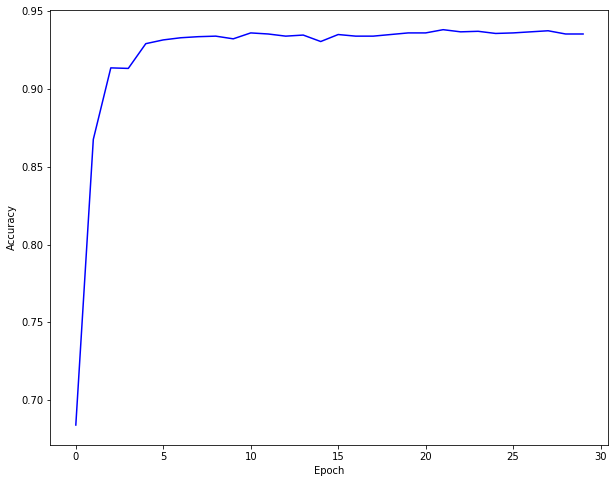

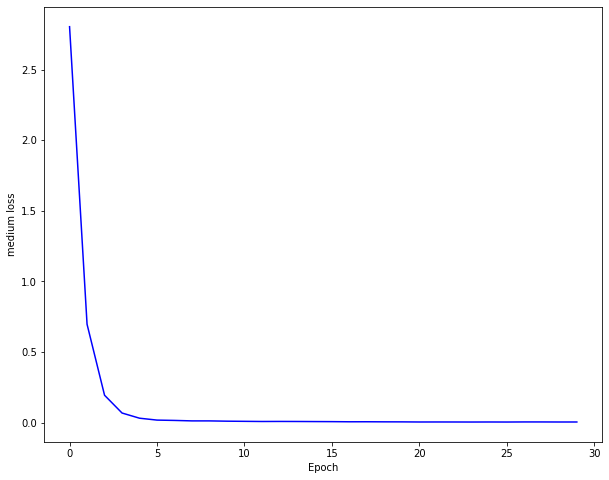

 score: 0.9378 

In [56]:
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = resnet.parameters() # all params
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
resnet = resnet.to(DEVICE) 
cudnn.benchmark
best_model_resnet=train_and_validate(NUM_EPOCHS,resnet,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)
accuracy=evaluate(best_model_resnet['model'],test_dataset,test_dataloader,'test')